In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import math

# plotting library
from matplotlib import pyplot as plt
# advanced statistics library
from scipy import stats


# Notebook 1: Flow Measurement using the Salt Dilution Method

## Introduction

[Flow measurement by salt dilution](https://doi.org/10.1002/hyp.3360070212)$^{[1]}$ is a type of tracer method where the natural conductivity of stream water is temporarily raised by adding (dissolving) a known mass of tracer into the stream, and measuring a response downstream.  Tracer methods can be done by slug injection or steady-state.  A "slug" is a known mass of tracer that dissolves and mixes in the stream.  The steady-state method is a constant injection of a dissolved tracer of known concentration.  Both methods are suited to lower flows where a sufficient signal-to-noise ratio can be acheived with a relatively small amount of tracer, and to turbulent flows where adequate mixing of the tracer can be achieved.  Table salt is commonly used for measurement because it is cheap and practical for field measurement, and the concentration and durations are small compared to [observed levels of toxicity](https://doi.org/10.1016/j.envpol.2017.01.040)$^{[2]}$.  

This notebook introduces the instrument calibration and measurement data processing for a salt dilution streamflow measurement using the slug tracer method.  More information on the steady-state method can be found [here](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.454.1620&rep=rep1&type=pdf&bcgovtm=new%20west%20record).  At the end of this notebook, there is an open ended question that asks you to reflect on the content of the notebook.

### Given Information:

| Parameter | Value | Units |
|---|---|---|
| Date of Measurement | 26 September 2010 | -|
| Mass of Injected Salt | 100 | kg |
| Calibration Solution | 10.1 | $\frac{g}{L}$ |
| Calibration Volume | 500 | $mL$ |
| Calibration increments | 1.1 | $mL$ |

## Import the Salt Dilution Data

In a salt dilution measurement, we first calibrate the instrument using known concentrations of salt solution.  

The calibration data is provided in a file named **SD_cal.csv**, and it's saved under:
>`<project root>/content/notebook_data/notebook_1_data/`.

If you haven't done so, review the different ways we can specify file paths and navigate file structure in the [Data Import and Review](notebooks/Introduction/Data_Import_and_Review.ipynb) notebook.

In [2]:
data_file_path = '../../notebook_data/notebook_1_data/'
calibration_filename = 'SD_cal.csv' # this is the calibration data file
salt_dilution_filename = 'SD_data.csv' # this is the measurement data file

In [3]:
# instrument calibration data
# see how two strings can be combined with the '+' operator
print(data_file_path + calibration_filename)
sd_cal = pd.read_csv(data_file_path + calibration_filename)

# discharge measurement data
sd_data = pd.read_csv(data_file_path + salt_dilution_filename)

../../notebook_data/notebook_1_data/SD_cal.csv


Here we specify some known quantities concerning the calibration of our measurement device.  This information was recorded by the field staff and can be found in the SD_cal spreadsheet:

![Measurement calibration information found in the calibration spreadsheet file.](img/sd_cal_sheet.png)

In [4]:
# data given in the calibration file
cal_solution_concn = 10.0 # g/L - this is the NaCl concentration in the calibration solution (column A, row 11)
cal_vol = 500 # total calibration volume mL  (row 2 of Calibration volume column)
cal_vol_increment = 1.0 # [mL] increments for calibration solution (Calibration solution added (ml) column)

In [5]:
# display a preview of the calibration data
sd_cal.head()

,Calibration volume (ml),Calibration solution added (ml),Salt added (mg),Concentration (mg/l),Conductivity (microSiemens/cm),Temperature (C)
0,500,0.0,0.0,0.0,303.0,10.8
1,NaN,1.0,NaN,NaN,343.0,10.8
2,NaN,2.0,NaN,NaN,380.0,10.8
3,NaN,3.0,NaN,NaN,426.0,10.8
4,NaN,4.0,NaN,NaN,464.0,10.8


>**Note**: several columns contain `NaN`.  We need to update these columns based on the calibration procedure.  

The calibration procedure is as follows:
1.  Collect a sample of river water with a known volume (500mL is the first entry in the `Calibration Volume (ml)` column.)  Let's call this the **control sample**.
2.  Measure the baseline conductivity of the control sample.
3.  Add a known volume of calibration solution to the control sample (the `Calibration solution added (ml)` column indicates how much solution we add at each calibration step.  In this case, it's 1.0 millilitres.
4.  Measure the conductivity of the control sample.
5.  Repeat steps 3-4 until five measurements are recorded.

In [6]:
# update the calibration solution added column for the volume of calibration solution added during the calibration
# note that the index column can be used as a multiplier to give the correct cumulative calibration volume added
sd_cal['Calibration solution added (ml)'] = cal_vol_increment * sd_cal.index

#  add the volume of solution to the calibration volume
sd_cal['Calibration volume (ml)'] = cal_vol + sd_cal['Calibration solution added (ml)']

# calculate the equivalent salt mass added from the calibration solution volume
# and the calibration solution concentration.
sd_cal['Salt added (mg)'] = sd_cal['Calibration solution added (ml)'] * cal_solution_concn
sd_cal['Concentration (mg/l)'] = sd_cal['Salt added (mg)'] / (sd_cal['Calibration volume (ml)'] / 1000)

# drop empty rows
sd_cal.dropna(how='any', inplace=True)

In [7]:
# see how the calibration data has been updated
sd_cal

,Calibration volume (ml),Calibration solution added (ml),Salt added (mg),Concentration (mg/l),Conductivity (microSiemens/cm),Temperature (C)
0,500.0,0.0,0.0,0.000000,303.0,10.8
1,501.0,1.0,10.0,19.960080,343.0,10.8
2,502.0,2.0,20.0,39.840637,380.0,10.8
3,503.0,3.0,30.0,59.642147,426.0,10.8
4,504.0,4.0,40.0,79.365079,464.0,10.8
5,505.0,5.0,50.0,99.009901,505.0,10.8
6,506.0,6.0,60.0,118.577075,546.0,10.8


## Plot the calibration and best fit line

The sevel calibration points are plotted below as a series of red circles.  The best fit line through the calibration points is represented by a dashed blue line.    

>**Note**:  More information on specifying the appearance of plots can be found in the [matplotlib documentation](https://matplotlib.org/3.1.0/api/markers_api.html#module-matplotlib.markers). In the plot below, the red circle is specified by the short-form string `'ro'` and the dashed blue line is specified by the three character code `'b--'`.

The `stats.linregress` function takes in two arrays and returns the equation of the best fit line through the data, along with information about the fit.  Note that the r-value is the correlation coefficient.  The coefficient of determination ($R^2$) is the correlation coefficient squared.

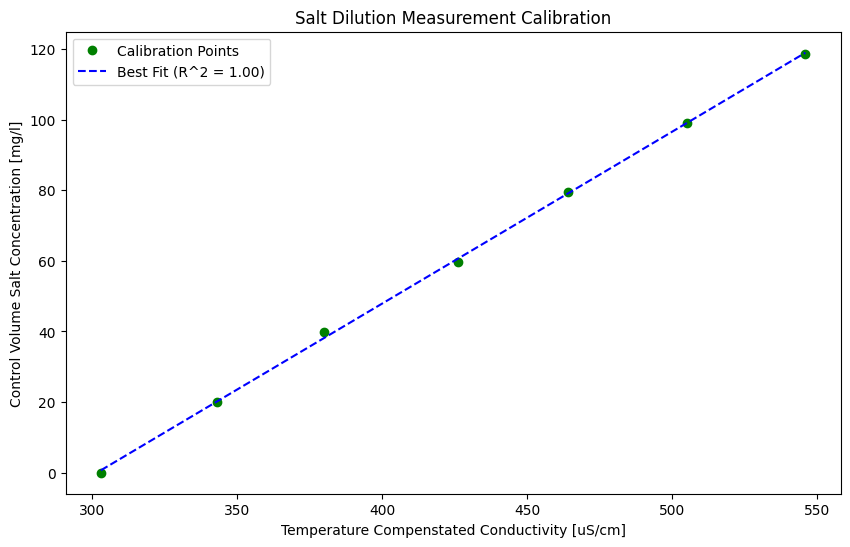

In [8]:
# initialize a single figure (the values 1, 1 can be changed to create a grid of plots)
fig, ax = plt.subplots(1, 1, figsize=(10,6))

# the .to_numpy() attribute converts to a vector in order to do vector operations
cond_series = sd_cal['Conductivity (microSiemens/cm)'].to_numpy()
conc_series = sd_cal['Concentration (mg/l)'].to_numpy()

# add the calibration points to the plot
ax.plot(cond_series, conc_series, 'go', label="Calibration Points")

ax.set_xlabel('Temperature Compenstated Conductivity [uS/cm]')
ax.set_ylabel('Control Volume Salt Concentration [mg/l]')
ax.set_title('Salt Dilution Measurement Calibration')

# add best fit line
results = stats.linregress(cond_series, conc_series)
# the stats.linregress output is a 5-tuple, r_value is the correlation coefficient
slope, intercept, r_value, p_value, std_err = results

#  create an array between the minimum and maximum calibration points
x_range = np.linspace(cond_series.min(), cond_series.max(),  100)

# use the best fit slope and intercept to construct the best fit line
best_fit = [x * slope + intercept for x in x_range]

# add the best fit line to the plot
ax.plot(x_range, best_fit, 'b--', label='Best Fit (R^2 = {:.2f})'.format(r_value**2))
# by default a legend is not shown, so we need to call the attribute.
plt.legend()

### Best Fit slope and coefficient of determination ($R^2$) of calibration points

In [9]:
#note: the number of decimals in the slope is too low. adjust the line below to print one more decimal.
print(f"The calibration best fit slope is {slope:.2f} [[mg/L] / [uS/cm]]")
print(f"The coefficient of determination of the calibration is {r_value**2:.3f}.")

The calibration best fit slope is 0.49 [[mg/L] / [uS/cm]]
The coefficient of determination of the calibration is 1.000.


>**Note**: Above, the print statement string has an `f` before the opening quotation `"`, which enables the insertion of variables into the string.  This is done using the `{}` symbol and a 'type' specifier.  In this case, the values inside the curly brackets `{slope:.2f}` means I want a **float** of **2** decimal places.  There are a number of ways to insert variables into strings for output.  More information on string formatting can be [found here](https://www.python.org/dev/peps/pep-3101/).

## Flow measurement

### Plot the salt dilution measurement

Now we'll use the second data file.  Recall that the first file was for calibration.  The EC sensor was placed in a measured volume of water, and calibration solution was added in measured amounts to record the change in conductivity.  

For the actual measurement of flow in the creek, the EC sensor is placed in the creek some distance downstream of the where a known mass of salt is deposited and mixed.

Below we plot the conductivity over time, and we also determine what the 'background' conductivity was in order to calculate the area under the conductivity curve.  It turns out there is a lot of interesting information about runoff processes contained in the background EC signal.

In [10]:
sd_data

,Time (s),ECT (uS/cm),Temperature (C)
0,1,298,10.8
1,2,298,10.8
2,3,298,10.8
3,4,298,10.8
4,5,298,10.8
...,...,...,...
863,864,298,10.5
864,865,298,10.5
865,866,298,10.5
866,867,298,10.5


<AxesSubplot: xlabel='Time (s)'>

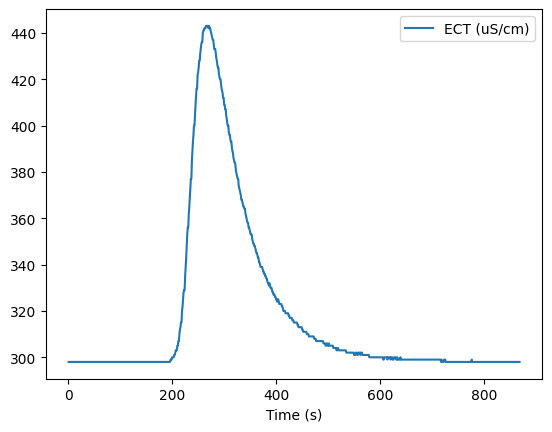

In [11]:
# we can also plot directly from a dataframe
sd_data.plot('Time (s)', 'ECT (uS/cm)')

### Specify background and measurement periods

We need to establish the background conductivity, or the natural conductivity of the stream prior to the measurement.  Use the plot above to establish a first guess at both the background period and the measurement period.

In [12]:
# the background is the natural level of conductivity prior to the salt injection
start_bg = 0  # set the time (in seconds) for the start point of the background
end_bg = 150  # set the time (in seconds) for the end point of the background

# start and end time of the measurement (seconds)
msmt_start = 190
msmt_end = 700

# here, the mean of the background over a certain period is calculated as the representative background EC.T
background_ect = sd_data['ECT (uS/cm)'].iloc[start_bg: end_bg].mean()

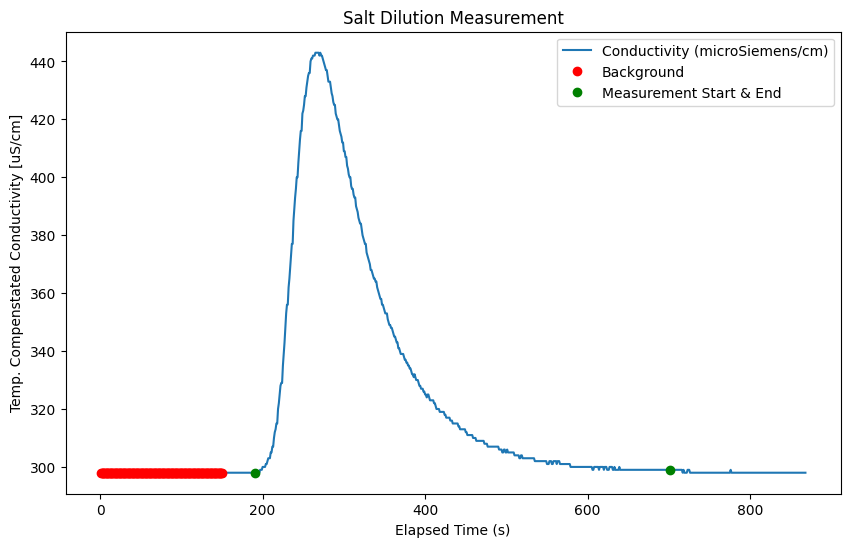

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

# plot the conductivity vs. time
t = sd_data['Time (s)'].to_numpy()
ec_t = sd_data['ECT (uS/cm)'].to_numpy()

ax.plot(t, ec_t, label="Conductivity (microSiemens/cm)")

# label the axes, and set the plot title
ax.set_xlabel('Elapsed Time (s)')
ax.set_ylabel('Temp. Compenstated Conductivity [uS/cm]')
ax.set_title('Salt Dilution Measurement')

ax.plot(t[start_bg: end_bg], 
        ec_t[start_bg: end_bg], 'ro',
        label='Background')

ax.plot((t[msmt_start], t[msmt_end]),
        (ec_t[msmt_start], ec_t[msmt_end]), 'go',
        label='Measurement Start & End')

plt.legend()

## Calculate Discharge

The volumetric flow (discharge) is equal to the area under the salt dilution curve, minus the background EC.

Calculate the area under the curve:

The area is: $$A_{curve} = \sum_{i=start}^{end} (ECT_i - ECT_{BG,i}) \cdot Slope_{calibration} \cdot t_{step,i} = \frac{\mu S}{cm} \cdot \frac {mg/L}{\mu S/cm} \cdot s = \frac {mg}{L} \cdot s$$
Then discharge (Q) is calculated by: $\frac{m_{salt}}{A_{curve}} = \frac{M\cdot kg \cdot \frac{1x10^6 mg}{1kg}}{\frac {mg}{L} \cdot \frac{1000 L}{1m^3} \cdot s} = \frac {m^3}{s}$

To illustrate, we are calculating the total area under the curve:

![Area under conductivity curve](img/a1.png)

And we are subtracting the rectangle representing the background.

![Background Area](img/a2.png)


In the cell below, we calculate the area under the conductivity curve (`ECT (uS/cm`) and subtract the background average determined above.  We do this by finite-difference, which is simply adding up all the little rectangles that approximate the green region in the diagram above.

In [14]:
# subtract the background and multiply by the calibration slope 
sd_data['Concentration'] = (sd_data['ECT (uS/cm)'] - background_ect) * slope

Check the time step duration.  We know from the column header the time units are in seconds (s), and we could look at the values and hard-code the time step, but it's better to not assume or hard code values, so we will use the actual time step by calling the `.diff()` function on the `Time (s)` column to get a row-wise difference.

In [15]:
sd_data['time_step'] = sd_data['Time (s)'].diff()

In [16]:
# trim the time series to the start and end time
msmt_slice = sd_data[(sd_data['Time (s)'] > msmt_start) & (sd_data['Time (s)'] < msmt_end)].copy()

# approximating the area under the curve as the sum of small 
# rectangles of height 'concentration' and widths of 1 time step
concentration_area = np.sum(np.multiply(msmt_slice['Concentration'], msmt_slice['time_step']))

>**Note**: The `np.muliply()` function used above does element-wise multiplication.  i.e. if $a=[0, 1, 2]$ and $b=[3, 4, 5]$, `np.multiply(a, b) = [0, 4, 10]`.  Consider what would happen if our timestep was not uniform and we used a constant multiplier to calculate area under the curve.

In [17]:
a = [0, 1, 2]
b = [3, 4, 5]
np.multiply(a, b)

array([ 0,  4, 10])

In [18]:
mass = 100 # 1 kg "slug" of salt (NaCl) was put in the river (as recorded in the SD_cal spreadsheet, shown previously)

# see the "Calculate Discharge" section above to convince yourself that the units work out
Q_calculated = mass * 1000 / concentration_area

print(f'The calculated discharge for the measurement is {Q_calculated:.1f} m^3/s')

The calculated discharge for the measurement is 11.9 m^3/s


## Notebook Reflection

In this notebook, we demonstrated how a salt dilution measurement is processed, including calibration and calculation of volumetric flow.  There are a number of sources of uncertainty in this process.  Provide short written responses to the questions below.  It is recommended to use this notebook to get a sense of the sensitivity of the resulting volumetric flow calculation to various input parameters.

Near the start of the notebook, we set variables associated with the calibration of the EC sensor:  
 * `cal_vol`: the volume of water from the stream used as the baseline for calibration,
 * `cal_solution_concn`: the concentration of our calibration solution, and 
 * `cal_vol_increment`: the incremental volume of calibration solution added to the calibration volume
 
### Question 1: 

Comment on the effect of errors in the *accuracy* of the three calibration variables.  Which variable results in the greatest change to the calculated discharge if the variable is changed by +/- 10%?  In other words, what is the *sensitivity* of the result (measured flow) to each of the three calibration variables, in relative, qualitative terms? 

### Question 2: 

Above, we manually set the start and end of the salt injection measurement (marked in the plot by the green dots) using the `msmt_start` and `msmt_end` variables.  In some flow conditions, the EC reading will take a very long time to return to baseline.  The realities of field work (time constraints, battery power, etc) occassionally result in the 'tail' of the measurement curve being cut off.  What happens to the calculated discharge if the EC measurement stops unexpectedly before the EC returns to baseline?  Go back in the notebook and change the `msmt_end` time and comment on the effect on the calculated discharge.

## Additional Info

### Temperature Compensation for Conductivity

The electrical conductivity (EC) of water is a function of temperature, so it is important that the water used for calibration is the same temperature as the water in the stream being measured.  Alternatively, a temperature correction can be applied.  For the data in this notebook, the instrument used for flow measurement has a thermometer, so temperature compensation is built into the instrument.

Two different methods of temperature compensation are provided below for reference, the first is an [EU standard for the determination of electrical conductivity](https://standards.iteh.ai/catalog/standards/cen/3978cdbc-b72f-459e-9275-99e7fc2b4b84/en-27888-1993), and the second is a [linear approximation of conductivity]()$^{[3]}$ as a function of temperature.

In [ ]:
def eu_std_ect_adjust(temp, ec):
    """
    Takes in a temperature (Theta), and an EC value,
    returns a temperature adjusted ECT value
    based on EU standard 27888 conversion.
        Input:  -temperature (Celsius)
                -electrical conductivity
    """
    c1 = -0.198058
    c2 = -1.992186
    c3 = 231.17628
    c4 = 86.39123
    r = c1 + math.exp(c2 + c3 / (temp + c4))
    c5 = 0.962144
    c6 = 0.965078
    c7 = 1.116
    f25 = ((1 - c5) + c5 * (r**c6)) * c7
    return ec * f25

def linear2_ect_adjust(temp, ec):
    """
    Takes in a temperature (temp), and an EC value (ec),
    returns a temperature adjusted ECT value
    based on linear interpolation assuming
    2.5% per degree centigrade. (Smith, 1962)
    """
    f25 = 2.5
    return ec / (1 + (f25 /100) * (temp - 25))


In [ ]:
# Apply temperature compensation to the measured conductivity
temp_compensated = []
for i, row in sd_cal.iterrows():
    conductivity = row['Conductivity (microSiemens/cm)']
    temperature = row['Temperature (C)']

    # for each value in the conductivity time series,
    # apply the function to correct for temperature,
    # and add to the temp compensated array
    temp_ec = eu_std_ect_adjust(temp=temperature, ec=conductivity)
    
    temp_compensated.append(temp_ec)

## References


1. Kite, Geoff. "Computerized streamflow measurement using slug injection." *Hydrological processes* 7.2 (1993): 227-233.
2. Hintz, William D., and Rick A. Relyea. "Impacts of road deicing salts on the early-life growth and development of a stream salmonid: salt type matters." *Environmental pollution* 223 (2017): 409-415.
3. Smith, Stanford H. "TEMPERATURE CORRECTION IN CONDUCTIVITY MEASUREMENTS 1." *Limnology and Oceanography* 7.3 (1962): 330-334.
